In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda



In [2]:
print(torch.__version__)

2.2.1


In [3]:
# Set font to match Latex
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
})

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())


In [5]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [6]:
train_image = []
train_target = []

for data in mnist_trainset:
    image, target = data
    train_image.append(image)
    train_target.append(target)

In [7]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
test_image = []
test_target = []

for data in mnist_testset:
    image, target = data
    test_image.append(image)
    test_target.append(target)

7


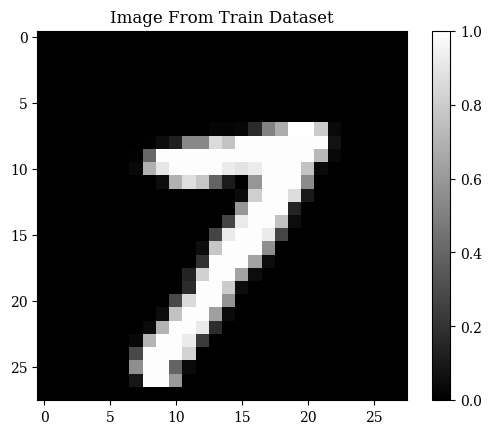

In [33]:
print(train_target[40000])
plt.imshow(train_image[40000].view(28,28), cmap='gray')
plt.colorbar()
plt.title('Image From Train Dataset')
plt.savefig('trainDataSetnr.pdf')

9


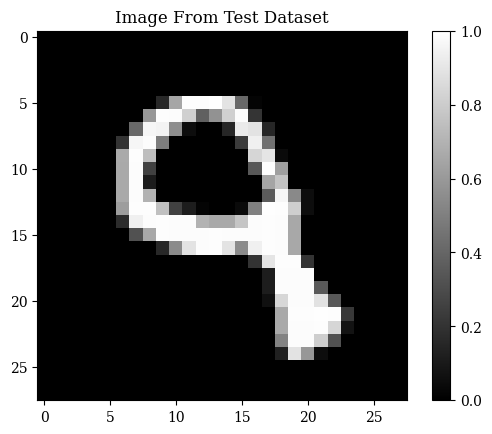

In [32]:
print(test_target[4000])
plt.imshow(test_image[4000].view(28,28), cmap='gray')
plt.colorbar()
plt.title('Image From Test Dataset')
plt.savefig('testDataSetnr.pdf')